In [1]:
%matplotlib inline

import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
from rdkit import rdBase
print(rdBase.rdkitVersion)

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

2019.03.4


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [2]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [3]:
n = 200 # balance sets equally
actives = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('./data/try1_decoys_final.ism')[:n] ]

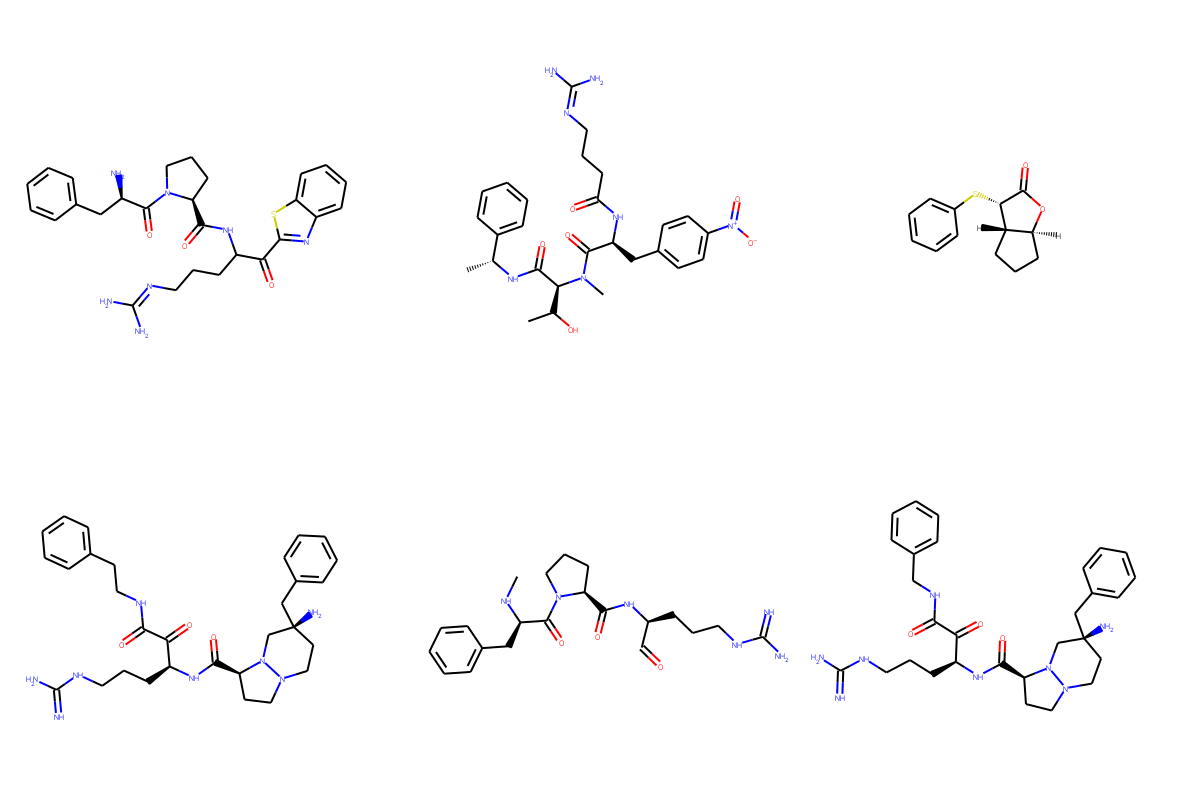

In [4]:
img = Draw.MolsToGridImage( actives[:6], molsPerRow=3, subImgSize=(400, 400))
img

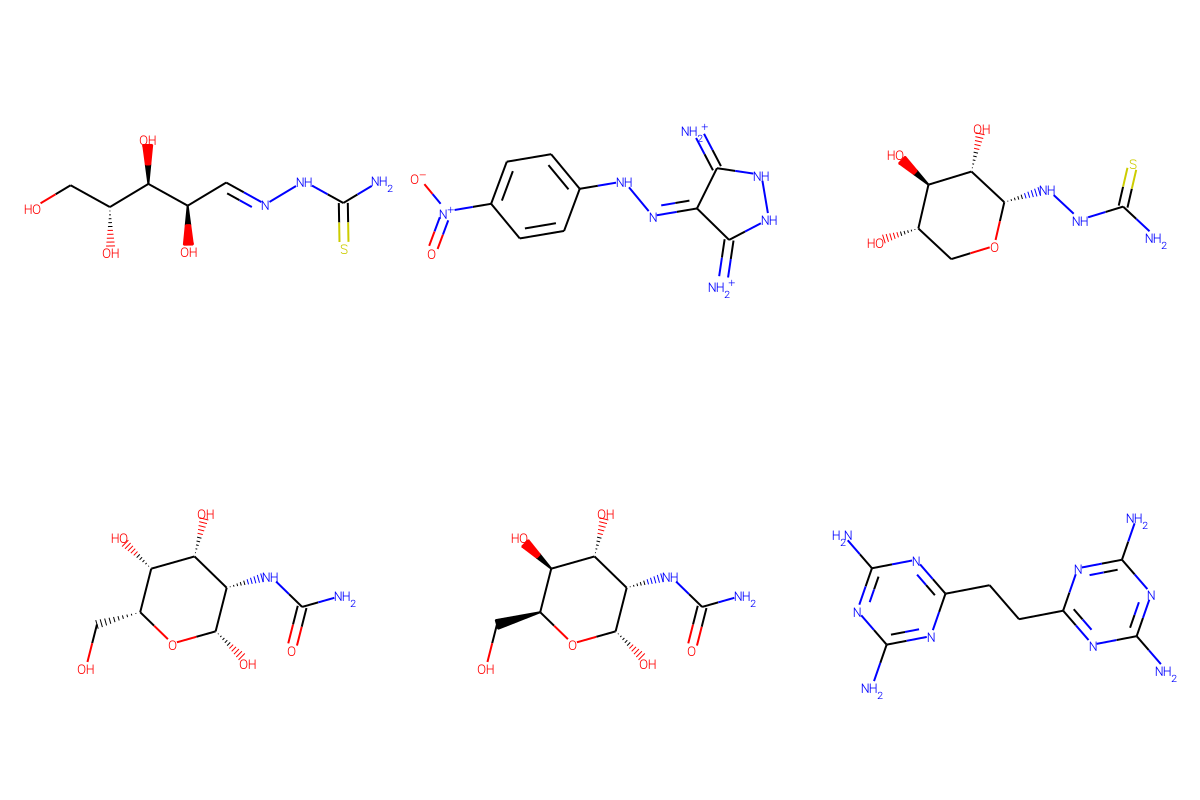

In [5]:
img = Draw.MolsToGridImage( decoys[:6], molsPerRow=3, subImgSize=(400, 400))
img

We need to generate properties for each molecule in the actives and decoy testing sets. <font color="red">Warning: This is sloppy programming!</font>

In [6]:
mol = pd.Series(decoys + actives)
target_classes = np.array(['DECOY', 'ACTIVE'])
mol_labels = pd.Series(([target_classes[0]] * n) + ([target_classes[1]] * n))
df = pd.DataFrame()
df['molecule'] = mol
df['class'] = mol_labels
df['heavy_atom_count'] = [ float(Descriptors.HeavyAtomCount(m)) for m in df['molecule'] ]
df['heteroatoms_count'] = [ float(Descriptors.NumHeteroatoms(m)) for m in df['molecule'] ]
df['mol_weight'] = [ Descriptors.MolWt(m) for m in df['molecule'] ]
df['rot_bonds'] =  [ float(Descriptors.NumRotatableBonds(m)) for m in df['molecule'] ]
df['h_donors'] =   [ float(Descriptors.NumHDonors(m)) for m in df['molecule'] ]
df['h_acceptors'] = [ float(Descriptors.NumHAcceptors(m)) for m in df['molecule'] ]
df['log_p'] = [ Descriptors.MolLogP(m) for m in df['molecule'] ]
df['balabanj'] = [ Descriptors.BalabanJ(m) for m in df['molecule'] ]
df['mol_mr'] = [ Descriptors.MolMR(m) for m in df['molecule'] ] # molar refractivity
df['ring_count'] = [ float(Descriptors.RingCount(m)) for m in df['molecule'] ]
df['ring_aromatic'] = [ float(Descriptors.NumAromaticRings(m)) for m in df['molecule'] ]
df['ring_saturated'] = [ float(Descriptors.NumSaturatedRings(m)) for m in df['molecule'] ]
df['ring_aliphatic'] = [ float(Descriptors.NumAliphaticRings(m)) for m in df['molecule'] ]
df['tpsa'] = [ Descriptors.TPSA(m) for m in df['molecule'] ]
df['chi0'] = [ Descriptors.Chi0(m) for m in df['molecule'] ]
df['chi1'] = [ Descriptors.Chi1(m) for m in df['molecule'] ]
df['nhoh'] = [ float(Descriptors.NHOHCount(m)) for m in df['molecule'] ]
df['no'] = [ float(Descriptors.NOCount(m)) for m in df['molecule'] ]
#df['amide_bonds'] = [ Descriptors.NumAmideBonds(m) for m in df['molecule'] ]
df['csp3'] = [ Descriptors.FractionCSP3(m) for m in df['molecule'] ]
df['hallkieralpha'] = [ Descriptors.HallKierAlpha(m) for m in df['molecule'] ]
df['ipc'] = [ Descriptors.Ipc(m) for m in df['molecule'] ]
df['bertzct'] = [ Descriptors.BertzCT(m) for m in df['molecule'] ]
df['qed'] = [ Descriptors.qed(m) for m in df['molecule'] ]
df['kappa1'] = [ Descriptors.Kappa1(m) for m in df['molecule'] ]
df['kappa2'] = [ Descriptors.Kappa2(m) for m in df['molecule'] ]
df['kappa3'] = [ Descriptors.Kappa3(m) for m in df['molecule'] ]
df

,molecule,class,heavy_atom_count,heteroatoms_count,mol_weight,rot_bonds,h_donors,h_acceptors,log_p,balabanj,...,nhoh,no,csp3,hallkieralpha,ipc,bertzct,qed,kappa1,kappa2,kappa3
0,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b670>,DECOY,14.0,8.0,223.254,5.0,6.0,6.0,-3.11960,3.993830,...,7.0,7.0,0.666667,-0.80,8.634210e+02,213.253298,0.165010,13.200000,6.623823,5.043490
1,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b6c0>,DECOY,18.0,9.0,249.234,3.0,5.0,4.0,-3.21430,2.103874,...,7.0,9.0,0.000000,-2.97,1.428210e+04,530.539508,0.282776,11.513498,4.491161,2.237596
2,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b710>,DECOY,14.0,8.0,223.254,2.0,6.0,6.0,-3.23680,2.422963,...,7.0,7.0,0.833333,-0.51,1.140633e+03,217.253298,0.213402,11.564129,4.823127,2.737778
3,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b760>,DECOY,15.0,8.0,222.197,2.0,6.0,6.0,-3.54540,2.697922,...,7.0,8.0,0.857143,-0.93,1.738804e+03,237.520300,0.285119,12.141073,4.727106,2.548368
4,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b7b0>,DECOY,15.0,8.0,222.197,2.0,6.0,6.0,-3.54540,2.697922,...,7.0,8.0,0.857143,-0.93,1.738804e+03,237.520300,0.285119,12.141073,4.727106,2.548368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b210>,ACTIVE,39.0,6.0,519.645,11.0,3.0,4.0,5.40077,1.586668,...,4.0,6.0,0.181818,-4.71,6.302892e+08,1403.335105,0.140140,27.328155,13.194243,7.417010
396,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b260>,ACTIVE,37.0,7.0,494.643,7.0,3.0,5.0,5.43844,1.366094,...,4.0,7.0,0.300000,-4.13,3.073328e+08,1447.741313,0.235065,24.559389,10.465533,5.354944
397,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b2b0>,ACTIVE,35.0,10.0,494.573,7.0,3.0,7.0,2.56277,1.546048,...,5.0,9.0,0.200000,-3.57,7.191928e+07,1358.279963,0.259564,24.551286,9.964360,5.409403
398,<rdkit.Chem.rdchem.Mol object at 0x7f28e642b300>,ACTIVE,36.0,11.0,507.572,8.0,4.0,7.0,2.43337,1.532234,...,6.0,10.0,0.160000,-4.06,1.111411e+08,1453.671519,0.269430,25.045501,9.895917,5.126224


In [7]:
features = df.columns[2:]
# View features names
features

Index(['heavy_atom_count', 'heteroatoms_count', 'mol_weight', 'rot_bonds',
       'h_donors', 'h_acceptors', 'log_p', 'balabanj', 'mol_mr', 'ring_count',
       'ring_aromatic', 'ring_saturated', 'ring_aliphatic', 'tpsa', 'chi0',
       'chi1', 'nhoh', 'no', 'csp3', 'hallkieralpha', 'ipc', 'bertzct', 'qed',
       'kappa1', 'kappa2', 'kappa3'],
      dtype='object')

In [8]:
y = np.array([1 if cls == "ACTIVE" else 0 for cls in df['class']])
target_names = np.array(["ACTIVE", "DECOY"])

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def nd_pca(data, dim):
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=dim))])
    X_t = pipeline.fit_transform(data)    
    print('explained variance ratio (first two components): %s' % str(pipeline.named_steps['pca'].explained_variance_ratio_))
    return X_t

explained variance ratio (first two components): [0.47301537 0.19583274]


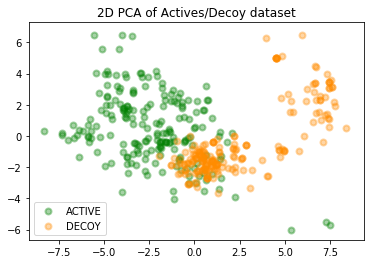

In [10]:
X = df[features]
X_t_2d = nd_pca(X, 2)

import pylab as plt
plt.figure()
colors = ['green', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [1, 0], target_names):
    plt.scatter(X_t_2d[y == i, 0], X_t_2d[y == i, 1], color=color, alpha=.35, lw=lw, label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('2D PCA of Actives/Decoy dataset')
plt.show()

In [11]:
X = df[features]
X_t_3d = nd_pca(X, 3)

explained variance ratio (first two components): [0.47301537 0.19583274 0.11029992]


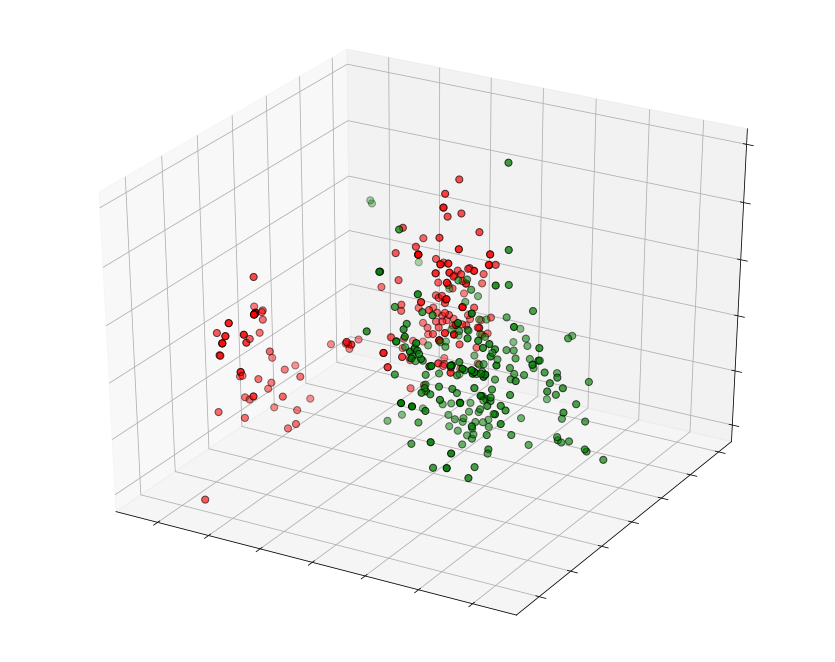

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -2], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(12, 9))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=120)


# Reorder the labels to have colors matching the cluster results
y = np.array(['g' if cls == "ACTIVE" else 'r' for cls in df['class']])
ax.scatter(X_t_3d[:, 0], X_t_3d[:, 1], X_t_3d[:, 2], c=y, s=50, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

# Practical Tasks

* How would you use PCA (dimensionality reduction) in an ML model?